In [1]:
import seaborn as sn
import numpy as np
%matplotlib inline

In [2]:
def cust_factorplot(x, y, hue, data, kind, palette, ax=None):
    sn.factorplot(x=x,y=y,hue=hue,data=data, kind=kind, palette=palette, ax=ax)
    sn.plt.close()
    ax.set_axis_bgcolor('white')
    ax.spines['bottom'].set_color('black')
    ax.set_xlabel("")
    ax.set_ylabel("weight")

In [3]:
def plot_cluster(cluster_name, which):
    entry = means_dict[cluster_name]
    vel_df = entry['vel_df']
    prox_df = vel_df = entry['prox_df']
    if which == 'velocity':
        fig, ax = sn.plt.subplots(1, figsize=(6,4))
        cust_factorplot(x='prox',y='weight',hue='vel',data=vel_df, kind='bar', palette=np.array(sn.color_palette())[[0,2]], ax=ax)
        ax.set_title('{}:\nVelocity Binned by Proximity'.format(cluster_name.replace('_', ' ').title()), ha='center')
    elif which == 'proximity':
        fig, ax = sn.plt.subplots(1, figsize=(6,4))
        cust_factorplot(x='vel',y='weight',hue='prox',data=prox_df, kind='bar', palette=np.array(sn.color_palette())[[1,3]], ax=ax)
        ax.set_title('{}:\nProximity Binned by Velocity'.format(cluster_name.replace('_', ' ').title()), ha='center')
    else:
        fig, (vel_ax, prox_ax) = sn.plt.subplots(1, 2, figsize=(12,4))
        cust_factorplot(x='prox',y='weight',hue='vel',data=vel_df, kind='bar', palette=np.array(sn.color_palette())[[0,2]], ax=vel_ax)
        vel_ax.set_title('{}:\nVelocity Binned by Proximity'.format(cluster_name.replace('_', ' ').title()), ha='center')
        cust_factorplot(x='vel',y='weight',hue='prox',data=prox_df, kind='bar', palette=np.array(sn.color_palette())[[1,3]], ax=prox_ax)
        prox_ax.set_title('{}:\nProximity Binned by Velocity'.format(cluster_name.replace('_', ' ').title()), ha='center')

In [4]:
import os
import pandas as pd

In [5]:
clust_files = [x for x in os.listdir() if x.endswith('.1D')]
clust_nums = [x.split('_')[1] for x  in clust_files]
clust_df = pd.DataFrame([clust_nums,clust_files]).T
clust_df.columns = ['number', 'mean_file']
clust_df.index = ['right_latIPS', 'left_latIPS',
                  'left_FEF', 'right_FEF',
                  'left_SMA', 'right_SMA',
                  'right_insula', 'left_insula',
                  'right_caudate', 'left_caudate',
                  'right_PAG', 'left_PAG',
                  'right_amygdala', 'MPFC']
means_dict = {row[0]: {'vel_df':pd.DataFrame([np.loadtxt(row[1].mean_file)[:,1],
                                              ['approach']*2 + ['retreat']*2,
                                              ['near', 'far', 'near', 'far']],
                                             index = ['weight', 'vel', 'prox']).T,
                       'prox_df':pd.DataFrame([np.loadtxt(row[1].mean_file)[:,0],
                                              ['approach']*2 + ['retreat']*2,
                                              ['near', 'far', 'near', 'far']],
                                             index = ['weight', 'vel', 'prox']).T
                       } for row in clust_df.iterrows()
                      }

In [6]:
from ipywidgets import interact, widgets
from IPython.display import display

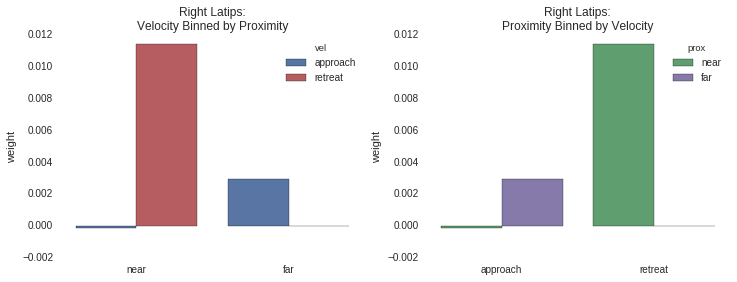

In [7]:
i = interact(plot_cluster,
             cluster_name=widgets.Select(options=clust_df.index.values.tolist(), 
                                         value='right_latIPS',
                                         description='Choose Region'),
             which=widgets.RadioButtons(options=['both', 'velocity', 'proximity'],
                                        value='both',
                                        description='')
            )